In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import scipy.stats as sts
import matplotlib.pyplot as plt
import requests

# Data 
claims = np.loadtxt('clms.txt')

# Question 1 (a)

### Summary Statistics

In [2]:
print("Summary Statistics:")
print("Mean =",np.mean(claims))
print("Median =", np.median(claims))
print("Maximum =", np.max(claims))
print("Minimum =", np.min(claims))
print("Standard Deviation =", np.std(claims))

Summary Statistics:
Mean = 720.2779753272437
Median = 172.21
Maximum = 227967.25
Minimum = 0.01
Standard Deviation = 3972.663756393663


### Plot 1

<IPython.core.display.Javascript object>


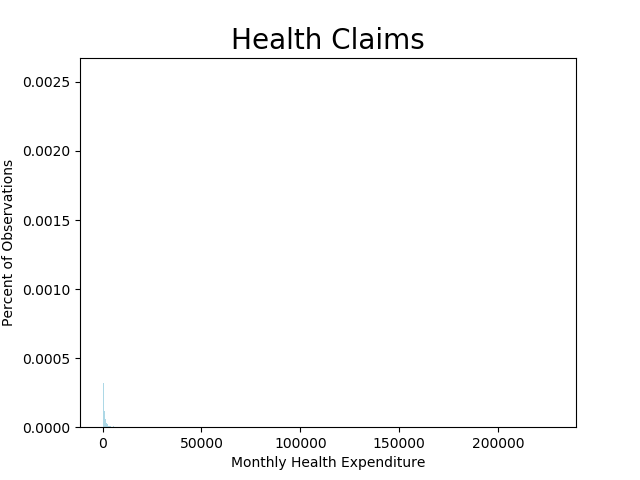

In [3]:
%matplotlib notebook

num_bins = 1000
plt.hist(claims, num_bins, density=True, color='lightblue')
plt.title('Health Claims', fontsize=20)
plt.xlabel(r'Monthly Health Expenditure')
plt.ylabel(r'Percent of Observations')
plt.show()

### Plot 2 

<IPython.core.display.Javascript object>


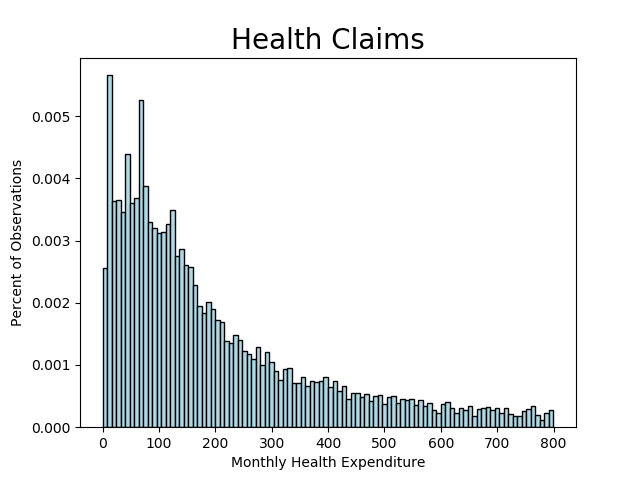

In [4]:
%matplotlib notebook
claims_800 = claims[claims <= 800]
wghts = (1 / len(claims)) * np.ones_like(claims_800)
num_bins = 100

plt.hist(claims_800, num_bins, density = True, weights = wghts, color='lightblue', edgecolor='k')
plt.title('Health Claims', fontsize=20)
plt.xlabel(r'Monthly Health Expenditure')
plt.ylabel(r'Percent of Observations')
plt.show()

### Comparing Plot 1 and Plot 2 

We might prefer plot 2 over plot 1 because we have more information about the shape of the distribution. Plot 1 includes all health claims such as the very few (small percentage of households) with high health claims relative to average. This is seen from how the maximum health expendiutre in the claims data is \$227967, while the mean is \$720 and standard deviation is \$3972. Therefore, it is harder to get a sense of the distribution when including all health expenditure data points.

# Question 1 (b)

### pdf of Gamma distribution

The pdf of the gamma distribution is the following:
$$ \text{(GA):}\quad f(x;\alpha,\beta) = \frac{1}{\beta^\alpha \Gamma(\alpha)}x^{\alpha-1}e^{-\frac{x}{\beta}},\quad x\in[0,\infty), \:\alpha,\beta>0 $$
$$ \text{where}\quad \Gamma(z)\equiv\int_0^\infty t^{z-1}e^{-t}dt $$

In [5]:
import scipy.special as spec

def gamma_pdf(params, xvals):
    '''
    -----------------------------------------------------------------------
    Generate pdf values from the gamma pdf with given alpha and beta values.
    -----------------------------------------------------------------------
    Inputs:
    params = (,) vector, ([alpha, beta])
    alpha  = scalar
    beta   = scalar
    xvals  = (N,) vector, values of the gamma distributed random
             variable

    Outputs: pdf values
    --------------------------------------------------------------------
    '''
    alpha, beta = params
    pdf_vals = (xvals**(alpha-1))*np.exp(-xvals/beta)/((beta**alpha) * spec.gamma(alpha))
    
    return pdf_vals

### Constructing the Criterion Function for the Maximum Likelihood Optimization Problem
    I have generalized the log_likelihood and criterion function so that I can use this function for
    different distributions. 

In [6]:
def log_lik(params, *args):
    '''
    --------------------------------------------------------------------
    Compute the log likelihood function for data xvals given pdf of 
    distribution and distribution parameters. 
    --------------------------------------------------------------------
    INPUTS:
    params = vector, depends on what parameters are needed for the 
             pdf
    args   = length 2 tuple, (xvals, pdf)
    xvals  = (N,) vector, values of the distribution
    pdf    = pdf of distribution want to do mle on
    
    Outputs: 
    log_lik_val = scalar, value of the log-likelihood function
    --------------------------------------------------------------------
    '''
    xvals, pdf = args
    pdf_vals = pdf(params, xvals)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_vals = ln_pdf_vals.sum()
    
    return log_lik_vals

In [7]:
def crit(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters, data, and pdf. This is for the minimization 
    version of the maximum likelihood optimization problem.
    --------------------------------------------------------------------
    INPUTS:
    params = vector, depends on what parameters are needed for the 
             pdf
    args   = length 2 tuple, (xvals, pdf)
    xvals  = (N,) vector, values of the distribution
    pdf    = pdf of distribution want to do mle on
    
    Outputs: 
    neg_log_lik_val = scalar, negative of log_lik_val
    --------------------------------------------------------------------
    '''
    log_lik_vals = log_lik(params, *args)
    neg_log_lik_vals = -log_lik_vals
    
    return neg_log_lik_vals

### Maximum Likelihood Optimization Problem

In [8]:
import scipy.optimize as opt

# Initial Guess
beta_0 = np.var(claims) / np.mean(claims)
alpha_0 = np.mean(claims) / beta_0
params_init = np.array([alpha_0, beta_0])

mle_args = (claims, gamma_pdf)
bnds = ((1e-10, None), (1e-10, None))
results_cstr_GA = opt.minimize(crit, params_init, args=mle_args, bounds=bnds, method='L-BFGS-B')
alpha_mle, beta_mle = results_cstr_GA.x

In [9]:
results_cstr_GA

      fun: 82076.45160566256
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.        , 0.09022187])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 8
   status: 0
  success: True
        x: array([2.21755323e-01, 2.19110647e+04])

### MLE Estimates and Log Likelihood Function value

In [10]:
print('alpha_mle =', alpha_mle) 
print('beta_mle =', beta_mle)
print('Log-likelihood =', -results_cstr_GA.fun)

alpha_mle = 0.22175532272679777
beta_mle = 21911.064699249375
Log-likelihood = -82076.45160566256


### Plot

<IPython.core.display.Javascript object>


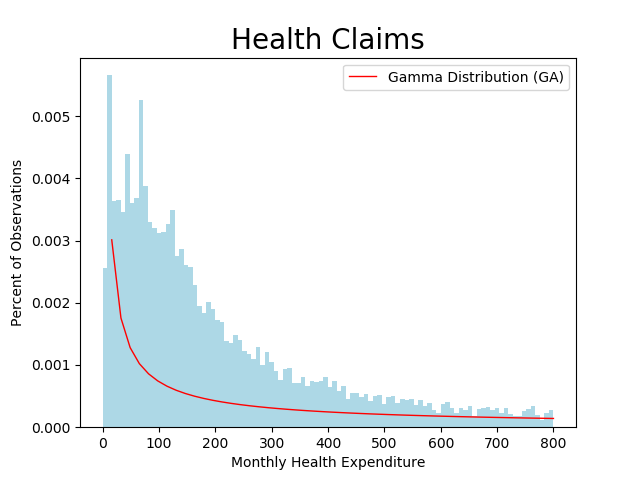

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power


In [11]:
# Plot Histogram
%matplotlib notebook
claims_800 = claims[claims <= 800]
wghts = (1 / len(claims)) * np.ones_like(claims_800)
num_bins = 100

plt.hist(claims_800, num_bins, density = True, weights = wghts, color='lightblue')
plt.title('Health Claims', fontsize=20)
plt.xlabel(r'Monthly Health Expenditure')
plt.ylabel(r'Percent of Observations')

dist_pts = dist_pts = np.linspace(0, 800)
params = (alpha_mle, beta_mle)
plt.plot(dist_pts, gamma_pdf(params, dist_pts), linewidth=1, color='r', label='Gamma Distribution (GA)')
plt.legend(loc='upper right')
plt.show()

# Question 1 (c)

### pdf of Generalized Gamma Distribution

The pdf of the generalized gamma distribution is the following:
$$ \text{(GG):}\quad f(x;\alpha,\beta,m) = \frac{m}{\beta^\alpha \Gamma\left(\frac{\alpha}{m}\right)}x^{\alpha-1}e^{-\left(\frac{x}{\beta}\right)^m},\quad x\in[0,\infty), \:\alpha,\beta,m>0 $$
$$ \text{where}\quad \Gamma(z)\equiv\int_0^\infty t^{z-1}e^{-t}dt $$

In [12]:
def gen_gamma_pdf(params, xvals):
    '''
    --------------------------------------------------------------
    Generate pdf values from the generalized gamma pdf with given
    alpha and beta values.
    --------------------------------------------------------------
    Inputs:
    params = (3,) vector, ([alpha, beta, m])
    alpha  = scalar 
    beta   = scalar
    m      = scalar 
    xvals  = (N,) vector, values of the generalized gamma distributed 
             random variable

    Outputs: pdf values  
    --------------------------------------------------------------
    '''
    alpha, beta, m = params
    pdf_values = (m*xvals**(alpha-1)*np.exp(-(xvals/beta)**m))/(beta**alpha * spec.gamma(alpha/m))
    
    return pdf_values

### Maximum Likelihood Optimization Problem 

Since we know that, 

$$ GA(\alpha,\beta) = GG(\alpha,\beta,m=1) $$

we will set our initial guess based on our estimates to $(\alpha_{mle}, \beta_{mle})$ from mle problem for the gamma distribution:

$$ \alpha_0 = \alpha_{mle} $$

$$ \beta_0 = \beta_{mle} $$

$$ m_0 = 1 $$



In [13]:
# Initial Guess
alpha_0 = alpha_mle 
beta_0 = beta_mle 
m = 1
params_init = np.array([alpha_0, beta_0, m])

mle_args = (claims, gen_gamma_pdf)
bnds = ((1e-10, None), (1e-10, None), (1e-10, None))
results_cstr_GG = opt.minimize(crit, params_init, args=mle_args, bounds=bnds, method='L-BFGS-B')
alpha_GG_mle, beta_GG_mle, m_GG_mle = results_cstr_GG.x

In [14]:
results_cstr_GG

      fun: 82076.44679085154
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.65544111,  0.09022187, -1.04482751])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 2
   status: 0
  success: True
        x: array([2.21737618e-01, 2.19110644e+04, 9.97091564e-01])

### MLE Estimates and Log Likelihood Function Value 

In [15]:
print('Estimates:')
print('alpha_mle =', alpha_GG_mle) 
print('beta_mle =', beta_GG_mle)
print('m =', m_GG_mle)
print('Log-likelihood =', -results_cstr_GG.fun)

Estimates:
alpha_mle = 0.22173761759457977
beta_mle = 21911.064431816903
m = 0.9970915637772736
Log-likelihood = -82076.44679085154


### Plot 

<IPython.core.display.Javascript object>


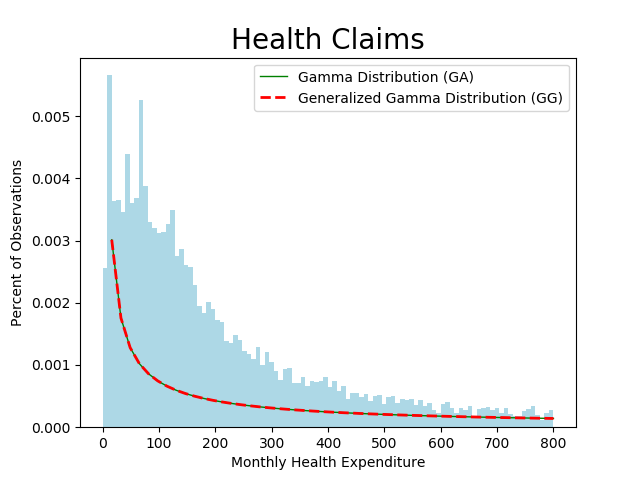

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power


In [16]:
# Plot histogram
%matplotlib notebook
claims_800 = claims[claims <= 800]
wghts = (1 / len(claims)) * np.ones_like(claims_800)
num_bins = 100

plt.hist(claims_800, num_bins, density = True, weights = wghts, color='lightblue')
plt.title('Health Claims', fontsize=20)
plt.xlabel(r'Monthly Health Expenditure')
plt.ylabel(r'Percent of Observations')

dist_pts = np.linspace(0, 800)
params1 = (alpha_mle, beta_mle)
params2 = np.array([alpha_GG_mle, beta_GG_mle, m_GG_mle])
plt.plot(dist_pts, gamma_pdf(params1, dist_pts), linewidth=1, color='g', label='Gamma Distribution (GA)')
plt.plot(dist_pts, gen_gamma_pdf(params2, dist_pts), linewidth=2, color='r', linestyle='dashed', 
         label='Generalized Gamma Distribution (GG)')
plt.legend(loc='upper right')

# Question 1 (d)

### pdf of Generalized Beta 2 Distribution

The pdf of the generalized beta 2 distribution is the following:
$$ \text{(GB2):}\quad f(x;a,b,p,q) = \frac{|a| x^{ap-1}}{b^{ap}B(p,q)\left(1 + \left(\frac{x}{b}\right)^a\right)^{p+q}},\quad x\in[0,\infty), \:a,b,p,q>0 $$
$$ \quad\text{where}\quad B(v,w)\equiv\int_0^1 t^{v-1}(1-t)^{w-1}dt $$

In [17]:
def gen_beta2_pdf(params, xvals):
    '''
    --------------------------------------------------------------
    Generate pdf values from the generalized gamma pdf with given
    alpha and beta values.
    --------------------------------------------------------------
    Inputs:
    params = (3,) vector, ([alpha, beta, m])
    alpha  = scalar 
    beta   = scalar
    m      = scalar 
    xvals  = (N,) vector, values of the generalized gamma distributed 
             random variable

    Outputs: pdf values
    --------------------------------------------------------------
    '''
    a, b, p, q = params
    pdf_vals = (np.abs(a)*(xvals/b)**(a*p))/(xvals*spec.beta(p,q)*(1+(xvals/b)**a)**(p+q))
    
    return pdf_vals

### Maximum Likelihood Optimization Problem 

Since we know that:
$$ GG(\alpha,\beta,m) = \lim_{q\rightarrow\infty}GB2\left(a=m,b=q^{1/m}\beta,p=\frac{\alpha}{m},q\right) $$

we will set our initial guess based on our estimates to $(\alpha_{mle}, \beta_{mle}, m_{mle})$ from mle problem for the generalized gamma distribution:

$$ a_0 = m_{mle} $$

$$ b_0 = q^{\frac{1}{m_{mle}}}*\beta_{mle} $$

$$ p_0 = \frac{\alpha_{mle}}{m_{mle}} $$

$$ q_0 = 10000 $$

In [20]:
# Initial Guess
a_0 = m_GG_mle
q_0 = 100000
b_0 = q_0**(1/m_GG_mle)*beta_GG_mle
p_0 = alpha_GG_mle 
params_init = np.array([a_0, b_0, p_0, q_0])

mle_args = (claims, gen_beta2_pdf)
bnds = ((1e-10, None), (1e-10, None), (1e-10, None), (1e-10, None))
results_cstr_GB2 = opt.minimize(crit, params_init, args=mle_args, bounds=bnds, method='L-BFGS-B')
a_GB2_mle, b_GB2_mle, p_GB2_mle, q_GB2_mle = results_cstr_GB2.x

In [21]:
results_cstr_GB2

      fun: 76696.01330794566
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-265.27268346,    0.        ,   27.58752089,  247.33308237])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 130
      nit: 15
   status: 0
  success: True
        x: array([7.60670363e-01, 2.26593828e+09, 8.22483687e-01, 1.00000038e+05])

### MLE Estimates and Log Likelihood Function Value 

In [22]:
print('Estimates:')
print('a_mle =', a_GB2_mle) 
print('b_mle =', b_GB2_mle)
print('p_mle =', p_GB2_mle)
print('q_mle =', q_GB2_mle)
print('Log-likelihood =', -results_cstr_GB2.fun)

Estimates:
a_mle = 0.7606703631882817
b_mle = 2265938275.480841
p_mle = 0.8224836866505549
q_mle = 100000.03807919992
Log-likelihood = -76696.01330794566


### Plot

<IPython.core.display.Javascript object>


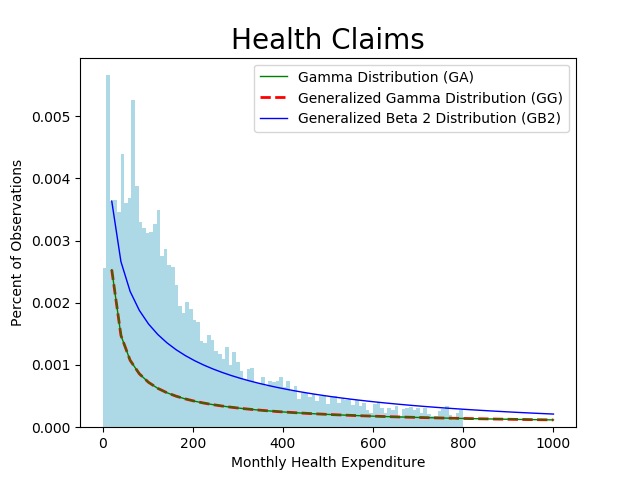

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [23]:
%matplotlib notebook
%matplotlib notebook
claims_800 = claims[claims <= 800]
wghts = (1 / len(claims)) * np.ones_like(claims_800)
num_bins = 100

plt.hist(claims_800, num_bins, density = True, weights = wghts, color='lightblue')
plt.title('Health Claims', fontsize=20)
plt.xlabel(r'Monthly Health Expenditure')
plt.ylabel(r'Percent of Observations')

dist_pts = np.linspace(0, 1000)
params1 = (alpha_mle, beta_mle)
params2 = np.array([alpha_GG_mle, beta_GG_mle, m_GG_mle])
params3 = np.array([a_GB2_mle, b_GB2_mle, p_GB2_mle, q_GB2_mle])
plt.plot(dist_pts, gamma_pdf(params1, dist_pts), linewidth=1, color='g', 
         label='Gamma Distribution (GA)', zorder=100)
plt.plot(dist_pts, gen_gamma_pdf(params2, dist_pts), linewidth=2, color='r', linestyle='dashed', 
         label='Generalized Gamma Distribution (GG)')
plt.plot(dist_pts, gen_beta2_pdf(params3, dist_pts), linewidth=1, color='b', 
         label='Generalized Beta 2 Distribution (GB2)')
plt.legend(loc='upper right')
plt.show()

# Question 1 (e)

We know from the Pearson's Chi-square test that, as sample size tends to infinity, under smothness conditions on probability density involved, null distribution of $2\Bigl(\ln\ell(\hat{\theta}_{MLE}) - \ln\ell(\tilde{\theta})\Bigr) \sim \chi^2(p) $ tends to chi-square distribution with degree of freedom based on the dimension of null hypothesis.

$$ LR(\tilde{\theta} |\hat{\theta}_{MLE}) = 2\Bigl(\ln\ell(\hat{\theta}_{MLE}) - \ln\ell(\tilde{\theta})\Bigr) \sim \chi^2(p) $$

$H_0$: GB2 specification

$H_1$: GA specification 

$H_1$: GG specification 

This is feasible because each distribution is a nested version of GB2. The degree of freedom of $LR(\tilde{\theta} |\hat{\theta}_{MLE})\sim \chi^2(p)$ is 4, which is consistent with the GB2.

In [24]:
# Log likelihood function for H_0 (GB2):
log_lik_GB2 = -results_cstr_GB2.fun

# Log likelihood function for H_1 (based on gamma distribution (GA)):
log_lik_GA = -results_cstr_GA.fun

# Log likelihood function for H_1 (based on generalized gamma distribution (GG)):
log_lik_GG = -results_cstr_GG.fun

In [25]:
def LR_test(log_lik_h0, log_lik_h1):
    '''
    --------------------------------------------------------------
    Computes likelihood ratio test statistic and returns value. 
    Pearson's statistic and liklihood ratio are asymptotically
    equivalent under H_0.
    --------------------------------------------------------------
    Inputs:
    log_lik_h1 = alternative hypothesis model specification
    log_lik_h0 = null hypothesis model specification

    Outputs: likelihood ratio test statistics value
    --------------------------------------------------------------
    '''
    LR_val = 2 * (log_lik_h0 - log_lik_h1)
    return LR_val

In [26]:
def p_val(log_lik_h0, log_lik_h1, n):
    '''
    --------------------------------------------------------------
    Computes the p_val based on likelihood ratio test 
    statistics (pearson's test statistics).
    --------------------------------------------------------------
    Inputs:
    log_lik_h1 = alternative hypothesis model specification
    log_lik_h0 = null hypothesis model specification
    n          = degrees of freedom based on dimension of null 
                 hypothesis

    Outputs: p value 
    --------------------------------------------------------------
    '''
    LR_val = LR_test(log_lik_h0, log_lik_h1)
    pval_h0 = 1.0 - sts.chi2.cdf(LR_val, n)
    return pval_h0

### Chisquared value from likelihood ratio test for estimated GA

In [27]:
LR_val = LR_test(log_lik_GB2, log_lik_GA)
pval_h0 = p_val(log_lik_GB2, log_lik_GA, 4)
print('Chi squared value = ', LR_val)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

Chi squared value =  10760.876595433801
chi squared of H0 with 2 degrees of freedom p-value =  0.0


### Chisquared value from likelihood ratio test for estimated GG

In [28]:
LR_val = LR_test(log_lik_GB2, log_lik_GG)
pval_h0 = p_val(log_lik_GB2, log_lik_GG, 4)
print('Chi squared value = ', LR_val)
print('Chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

Chi squared value =  10760.866965811758
Chi squared of H0 with 2 degrees of freedom p-value =  0.0


### Interpretation

We have a p-value of about 0 for both likelihood ratio test (Peason's test). Pearson's Chi-square statistics is both about 10439. We can interet the p-value as: if the null hypothesis is true, discrepancies this large would be expected to occur on the basis of chance about 100% of the time. Therefore, we can reject the null hypothesis.  

# Question 1 (f) 

### GB2 distribution case

In [29]:
import scipy.integrate as integrate
params = np.array([a_GB2_mle, b_GB2_mle, p_GB2_mle, q_GB2_mle])
prob = 1 - integrate.quad(lambda x: gen_beta2_pdf(params, x), 0, 1000)[0]
prob

0.1750746297551503

When using GB2 distribution from part (d), I have a chance of about 18% that I have a monthly health care claim of more than $1000.

### GA distribution case

In [30]:
params = np.array([alpha_mle, beta_mle])
prob = 1 - integrate.quad(lambda x: gamma_pdf(params, x), 0, 1000)[0]
prob

0.45195974447840703

When using GA distribution from part (d), I have a chance of about 45% that I have a monthly health care claim of more than $1000.

# Question 2 (a)

Data on ($c_t, k_t, w_t, r_t$) are given. We will use the following set of equations for estimation: 

$$(c_t)^{-1} -\beta E[r_{t+1}(c_{t+1})^{-1}] = 0$$ 

$$ c_t+ k_{t+1} - w_t - r_tk_t = 0 $$

$$ w_t-(1-\alpha)(e)^{z_t}(k_t)^\alpha = 0 $$

$$ r_t - \alpha (e)^{z_t}(k_t)^{\alpha-1} =0 $$

$$z_t = \rho z_{t-1} + (1-\rho)\mu + \epsilon_t $$ 
$$\mbox{where }\epsilon_t \sim N(0, \sigma^2)$$

### Data 

In [31]:
data = np.loadtxt('MacroSeries.txt', delimiter=',')
df = pd.DataFrame(data, columns = ['ct', 'kt', 'wt', 'rt'])
df.head()

,ct,kt,wt,rt
0,1.067109e+07,8.040697e+06,1.059438e+07,0.954120
1,1.169487e+07,7.595072e+06,1.161079e+07,1.107009
2,9.292394e+06,8.323735e+06,9.225588e+06,0.802596
3,7.913165e+06,6.613792e+06,7.856274e+06,0.860176
4,8.140994e+06,5.632136e+06,8.082466e+06,1.039183


In [32]:
ct, kt, wt, rt = np.loadtxt('MacroSeries.txt', unpack=True, delimiter=",")

### Approach

We will take the following approach to solve this problem: 

(1) We will guess $\alpha, \rho, \mu, \sigma$ and use $w_t, k_t$ data to back out a series for $z_t$

(2) We know from equation (5) that $Z_{t+1} \sim N(\rho z_{t-1} + (1-\rho) \mu, \sigma^2)$

### Sequence of Zt from data and equation (3)

$$ w_t-(1-\alpha)(e)^{z_t}(k_t)^\alpha = 0 $$

$$\Leftrightarrow z_t = \log(w_t) - \log(1-\alpha)-\alpha\log(k_t)$$

In [33]:
def seq_zt1(wt, kt, alpha):
    '''
    --------------------------------------------------------------
    Generate a series of Zt (total factor productivity) values 
    based on (wt, kt) data and alpha from equation (3). 
    --------------------------------------------------------------
    Inputs:
    wt     = (N,) vector, values of the wage per unit of labor in 
             period t
    kt     = (N,) vector, values of total household saving and 
             investment in period t
    alpha  = scalar

    Outputs: sequence of Zt values (N,) vector, which represent total 
             factor productivity in period t
    --------------------------------------------------------------
    '''
    zt = np.log(wt) - np.log(1-alpha) - alpha*np.log(kt)
    return zt

    I have generalized the zt_normal_pdf function so that I can use this function for different parameters used to 
    construct sequence of Zt (equation (3) or (4)). 
    
    Note: The following function zt_normal_pdf code will not run unless you run the code for the function seq_zt2.  
    However, I have placed the seq_zt2 code under (b) for stylistic reasons. To run the following code, please run 
    code for function seq_zt2 first under (b). 

In [39]:
def zt_normal_pdf(params, args):
    '''
    --------------------------------------------------------------
    Since we know that zt follows a normal distribution from 
    equation (5), we can find the pdf values of zt under this normal 
    distribution given parameters. 
    --------------------------------------------------------------
    Inputs:
    params = (4,) vector, ([alpha, rho, mu, sigma])
    alpha  = scalar
    rho    = scalar
    mu     = scalar
    sigma  = scalar
    args   = length 3 tuple, depends on what data using to consturct sequence 
             of zt. If using seq_zt1, tuple of (wt, kt, seq_zt1). If using 
             seq_zt2, tuple of (rt, kt, seq_zt2). Last element in tuple defines
             which equation to use to construct sequence of zt. 
    wt     = (N,) vector, values of the wage per unit of labor in period t
    kt     = (N,) vector, values of total household saving and investment in
             period t 
    rt     = (N,) vector, values of interest rate of return on investment in 
             period t

    Outputs: pdf values 
    --------------------------------------------------------------
    '''
    alpha, rho, mu, sigma = params 
    fun = args[-1]
    
    if fun == seq_zt1:
        wt, kt, fun = args
        zt = fun(wt, kt, alpha)
        
    if fun == seq_zt2:
        rt, kt, fun = args
        zt = fun(rt, kt, alpha)
        
    zt_lag = np.roll(zt, 1) 
    zt_lag[0] = mu 
    pdf_vals = sts.norm.pdf(zt, loc = rho*zt_lag + (1-rho)*mu, scale = sigma)
    return pdf_vals  

### Constructing the Criterion Function for the Maximum Likelihood Optimization Problem
    I have generalized the log_likelihood and criterion function so that I can use this function for
    different parameters used to construct sequence of Zt (equation (3) or (4)). 

In [40]:
def log_lik_zt(params, args):
    '''
    --------------------------------------------------------------------
    Compute the log likelihood function given pdf of distribution 
    and distribution parameters. 
    --------------------------------------------------------------------
    Inputs:
    params = (4,) vector, ([alpha, rho, mu, sigma])
    alpha  = scalar
    rho    = scalar
    mu     = scalar
    sigma  = scalar
    args   = length 3 tuple, depends on what data using to consturct sequence 
             of zt. If using seq_zt1, tuple of (wt, kt, seq_zt1). If using 
             seq_zt2, tuple of (rt, kt, seq_zt2). Last element in tuple defines
             which equation to use to construct sequence of zt. 
    wt     = (N,) vector, values of the wage per unit of labor in period t
    kt     = (N,) vector, values of total household saving and investment in
             period t 
    rt     = (N,) vector, values of interest rate of return on investment in 
             period t
    
    Outputs: log likelihood value 
    --------------------------------------------------------------------
    '''
    pdf_vals = zt_normal_pdf(params, args)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_vals = ln_pdf_vals.sum()
    return log_lik_vals

In [41]:
def crit_zt(params, args):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters, data, and pdf. This is the minimization 
    version of the maximum likelihood optimization problem.
    --------------------------------------------------------------------
    Inputs:
    params = (4,) vector, ([alpha, rho, mu, sigma])
    alpha  = scalar
    rho    = scalar
    mu     = scalar
    sigma  = scalar
    args   = length 3 tuple, depends on what data using to consturct sequence 
             of zt. If using seq_zt1, tuple of (wt, kt, seq_zt1). If using 
             seq_zt2, tuple of (rt, kt, seq_zt2). Last element in tuple defines
             which equation to use to construct sequence of zt. 
    wt     = (N,) vector, values of the wage per unit of labor in period t
    kt     = (N,) vector, values of total household saving and investment in
             period t 
    rt     = (N,) vector, values of interest rate of return on investment in 
             period t
    
    Outputs: neg_log_lik_val
    --------------------------------------------------------------------
    '''
    log_lik_vals = log_lik_zt(params, args)
    neg_log_lik_vals = -log_lik_vals
    return neg_log_lik_vals

### Maximum Likelihood Optimization Problem 

In [42]:
# Initial Guess
alpha_0 = 0.8
zvec = seq_zt1(wt, kt, alpha_0)
rho_0 = 0.9
mu_0 = np.mean(zvec) # use mean of zt sequence 
sigma_0 = np.std(zvec) # use stdv of zt sequence

params_init = np.array([alpha_0, rho_0, mu_0, sigma_0])
mle_args = [wt, kt, seq_zt1]

bnds = ((1e-10, 1-1e-10), (-1+1e-10, 1-1e-10),(1e-10, None),(1e-10, None))
results1_cstr = opt.minimize(crit_zt, params_init, args=mle_args, bounds=bnds, method='L-BFGS-B')
alpha1_mle, rho1_mle, mu1_mle, sigma1_mle = results1_cstr.x
vcv1_mle = (results1_cstr.hess_inv).matmat(np.eye(4))

In [43]:
results1_cstr

      fun: -96.65373752152959
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.12925057, -0.00175362, -0.01026166, -0.01247145])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 250
      nit: 44
   status: 0
  success: True
        x: array([0.70206739, 0.47981153, 6.25437522, 0.09204463])

### MLE Estimates

In [44]:
print('Estimates:')
print('alpha_mle =', alpha1_mle) 
print('rho_mle =', rho1_mle)
print('mu_mle =', mu1_mle)
print('sigma_mle =', sigma1_mle)
print('Log-likelihood =', -results1_cstr.fun)

Estimates:
alpha_mle = 0.7020673865059807
rho_mle = 0.47981153277600014
mu_mle = 6.254375217572918
sigma_mle = 0.09204463069067582
Log-likelihood = 96.65373752152959


### Inverse Hessian Variance-Covariance Matrix

In [45]:
print('VCV_mle =', vcv1_mle)

VCV_mle = [[ 5.04037496e+00 -6.30829345e+00 -6.26268196e+01 -5.75207602e-01]
 [-6.30829345e+00  8.64514186e+00  7.92744450e+01  7.74500972e-01]
 [-6.26268196e+01  7.92744450e+01  7.79223887e+02  7.21246581e+00]
 [-5.75207602e-01  7.74500972e-01  7.21246581e+00  7.02446288e-02]]


### Magnitude of Standard Errors 

In [46]:
stderr_alpha_mle = np.sqrt(vcv1_mle[0,0])
stderr_rho_mle = np.sqrt(vcv1_mle[1,1])
stderr_mu_mle = np.sqrt(vcv1_mle[2,2])
stderr_sigma_mle = np.sqrt(vcv1_mle[3,3])
print('Standard error for alpha estimate =', stderr_alpha_mle)
print('Standard error for rho estimate =', stderr_rho_mle)
print('Standard error for mu estimate =', stderr_mu_mle)
print('Standard error for sigma estimate =', stderr_sigma_mle)

Standard error for alpha estimate = 2.2450779415646553
Standard error for rho estimate = 2.94026220856825
Standard error for mu estimate = 27.91458197785815
Standard error for sigma estimate = 0.2650370329142249


In [47]:
print('Relative standard error for alpha =', stderr_alpha_mle/alpha1_mle * 100)
print('Relative standard error for rho =', stderr_rho_mle/rho1_mle * 100)
print('Relative standard error for mu =', stderr_mu_mle/mu1_mle * 100)
print('Relative standard error for sigma =', stderr_sigma_mle/sigma1_mle * 100)

Relative standard error for alpha = 319.7809761165327
Relative standard error for rho = 612.7952347366587
Relative standard error for mu = 446.3208714985079
Relative standard error for sigma = 287.9440451066673


We learned in class that "estimators of the VCV matrix measure how flat the likelihood function is at the estimated parameter values in teh dimension of each estimated parameter. The Hessian is a matrix of second derivatives of the log likelihood function with respect to the parameters being chosen. The Hessian matrix therefore captures information about how the slope of the log likelihood function is changing in each direction." Thus, these high relative standard errors implies that the log likelihood function is mostly flat and that changing the guess by a little can have a significant effect on the parameter estimates, while having similar log likelihood values.

# Qustion 2 (b)

### Sequence of Zt from data and equation (4)

$$ r_t = \alpha\exp(z_t)(k_t)^{\alpha-1} $$

$$\Leftrightarrow z_t = \log(r_t) - \log(\alpha)-(\alpha-1)\log(k_t)$$

In [48]:
def seq_zt2(rt, kt, alpha):
    '''
    --------------------------------------------------------------
    Generate a series of Zt (total factor productivity) values 
    based on (rt, kt) data and alpha from equation (4). 
    --------------------------------------------------------------
    Inputs:
    rt     = (N,) vector, values of interest rate of return on 
             investment in period t
    kt     = (N,) vector, values of total household saving and 
             investment in period t
    alpha  = scalar

    Outputs: sequence of Zt values (N,) vector, which represent total 
             factor productivity in period t
    --------------------------------------------------------------
    '''
    zt = np.log(rt) - np.log(alpha) - (alpha-1)*np.log(kt)
    return zt

### Maximum Likelihood Optimization Problem 

In [50]:
# Initial Guess
alpha_0 = 0.9
zvec = seq_zt2(rt, kt, alpha_0)
rho_0 = 0.9
mu_0 = np.mean(zvec) # use mean of zt sequence 
sigma_0 = np.std(zvec) # use stdv of zt sequence

params_init = np.array([alpha_0, rho_0, mu_0, sigma_0])
mle_args = [rt, kt, seq_zt2]

bnds = ((1e-10, 1-1e-10),(-1+1e-10, 1-1e-10),(1e-10, None),(1e-10, None))
results2_cstr = opt.minimize(crit_zt, params_init, args=mle_args, bounds=bnds, method='L-BFGS-B')
alpha2_mle, rho2_mle, mu2_mle, sigma2_mle = results2_cstr.x
vcv2_mle = (results2_cstr.hess_inv).matmat(np.eye(4))

In [51]:
results2_cstr

      fun: -96.65373736995835
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0689738 ,  0.00071623, -0.00412683, -0.00658531])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 250
      nit: 33
   status: 0
  success: True
        x: array([0.70199236, 0.47991829, 5.07573453, 0.09204488])

### MLE Estimates 

In [52]:
print('Estimates:')
print('alpha_mle =', alpha2_mle) 
print('rho_mle =', rho2_mle)
print('mu_mle =', mu2_mle)
print('sigma_mle =', sigma2_mle)
print('Log-likelihood =', -results2_cstr.fun)

Estimates:
alpha_mle = 0.7019923610958795
rho_mle = 0.4799182887026946
mu_mle = 5.0757345280277155
sigma_mle = 0.09204488023327767
Log-likelihood = 96.65373736995835


### Inverse Hessian Variance-Covariance Matrix

In [53]:
print('VCV_mle =', vcv2_mle)

VCV_mle = [[ 3.63366969e+02 -2.25780286e+02 -6.19491612e+03 -1.01441110e+01]
 [-2.25780286e+02  1.41767527e+02  3.84934860e+03  6.30502806e+00]
 [-6.19491612e+03  3.84934860e+03  1.05614962e+05  1.72943368e+02]
 [-1.01441110e+01  6.30502806e+00  1.72943368e+02  2.83271373e-01]]


### Magnitude of Standard Errors 

In [54]:
stderr_alpha_mle = np.sqrt(vcv2_mle[0,0])
stderr_rho_mle = np.sqrt(vcv2_mle[1,1])
stderr_mu_mle = np.sqrt(vcv2_mle[2,2])
stderr_sigma_mle = np.sqrt(vcv2_mle[3,3])
print('Standard error for alpha estimate =', stderr_alpha_mle)
print('Standard error for rho estimate =', stderr_rho_mle)
print('Standard error for mu estimate =', stderr_mu_mle)
print('Standard error for sigma estimate =', stderr_sigma_mle)

Standard error for alpha estimate = 19.062186877162965
Standard error for rho estimate = 11.90661694649379
Standard error for mu estimate = 324.98455633696994
Standard error for sigma estimate = 0.5322324425207958


In [55]:
print('Relative standard error for alpha =', stderr_alpha_mle/alpha2_mle * 100)
print('Relative standard error for rho =', stderr_rho_mle/rho2_mle * 100)
print('Relative standard error for mu =', stderr_mu_mle/mu2_mle * 100)
print('Relative standard error for sigma =', stderr_sigma_mle/sigma2_mle * 100)

Relative standard error for alpha = 2715.4407844844645
Relative standard error for rho = 2480.9675369279043
Relative standard error for mu = 6402.709884499211
Relative standard error for sigma = 578.2314466289824


Similar to (b), these high relative standard errors imply that the log likelihood function is mostly flat and that changing the guess by a little can have a significant effect on the parameter estimates, while having similar log likelihood values.

# Question 2 (c)

We want to solve $Pr(r_t>1 | \hat{\theta}, k_t, z_{t-1})$. Here, from equation (4), $r_t = \alpha\exp(z_t)(k_t)^{\alpha-1}$. So, 

\begin{align*}
Pr(r_t>1 | \hat{\theta}, k_t, z_{t-1}) &= Pr(\alpha\exp(z_t)(k_t)^{\alpha-1} > 1 | \hat{\theta}, k_t, z_{t-1}) \\
&= Pr(z_t > - \log(\alpha)-(\alpha-1)\log(k_t) | \hat{\theta}, k_t, z_{t-1})
\end{align*} 

Here, from equation (4), $z_t = \log(r_t) - \log(\alpha)-(\alpha-1)\log(k_t)$. Therefore, we know that $- \log(\alpha)-(\alpha-1)\log(k_t) = z_t$ when $r_t=1$. Let's call such $z_t = z*$ given $\hat{\theta}$, $k_t$, $z_{t-1}$ Then, 

\begin{align*}
Pr(r_t>1 | \hat{\theta}, k_t, z_{t-1}) &= Pr(z_t > z* | \hat{\theta}, k_t, z_{t-1})
\end{align*} 

We know from equation (5) that $z_{t} \sim N(\rho z_{t-1} + (1-\rho) \mu, \sigma^2)$. Thus given the normal distribution of $z_t$, we can find the probability that $z_t$ is greater than z*.

### Solving for $z_t=z*$ using equation (4)

We can use function seq_zt2 to solve for $z*$ because it uses equation (4) to construct sequence of zt. Function seqzt2 takes in rt, kt, and alpha as inputs. We are given $k_t=7,500,000$ and we set $r_t=1$. We will use the MLE esimate for alpha from part (a), which is alpha1_mle.

In [56]:
alpha = alpha1_mle
z_star = seq_zt2(1, 7500000, alpha)
z_star

5.070122377525182

### $Pr(r_t>1 | \hat{\theta}, k_t, z_{t-1}) = Pr(z_t > z* | \hat{\theta}, k_t, z_{t-1})$
We are using the given parameter $z_{t-1}$, and MLE estimates for $\rho$ and $\sigma$, to get the distribution of $z_t$. Then, we solve $Pr(z_t > z* | \hat{\theta}, k_t, z_{t-1})$.

In [57]:
prob = 1 - sts.norm.cdf(z_star, loc = rho1_mle*10 + (1-rho1_mle)*mu1_mle, scale = sigma1_mle)
print('Pr(zt > z_star | theta, kt, z_(t-1) = ', prob)

Pr(zt > z_star | theta, kt, z_(t-1) =  1.0


### Solution

\begin{align*}
Pr(r_t>1 | \hat{\theta}, k_t, z_{t-1}) &= Pr(z_t > z* | \hat{\theta}, k_t, z_{t-1}) \\
&= 1.0
\end{align*} 